In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install classification-models-3D
#!pip install efficientnet-3D
!pip install segmentation-models-3D

In [ ]:
!pip install patchify

In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from keras import backend as K
from tensorflow.keras.callbacks import Callback

Segmentation Models: using `tf.keras` framework.


In [ ]:
train_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_original.npy')
train_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_mask.npy')
validation_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_original.npy')
validation_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_mask.npy')
test_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_original.npy')
test_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_mask.npy')

In [ ]:
print("Dimension of the 3D original image:", train_original_3D.shape)
print("Dimension of the 3D mask image:", test_mask_3D.shape)

Dimension of the 3D original image: (112, 128, 128, 64, 3)
Dimension of the 3D mask image: (16, 128, 128, 64, 2)


In [ ]:
# For data augmentation
def add_gaussian_noise(images, sigma=25):
    noisy_images = np.empty_like(images, dtype=np.float32)

    for i in range(images.shape[0]):
        gauss = np.random.normal(0, sigma, images[i].shape)
        noisy = np.clip(images[i] + gauss, 0, 255)
        noisy_images[i] = noisy

    return noisy_images.astype(np.uint8)

In [ ]:
train_original_3D = add_gaussian_noise(train_original_3D)

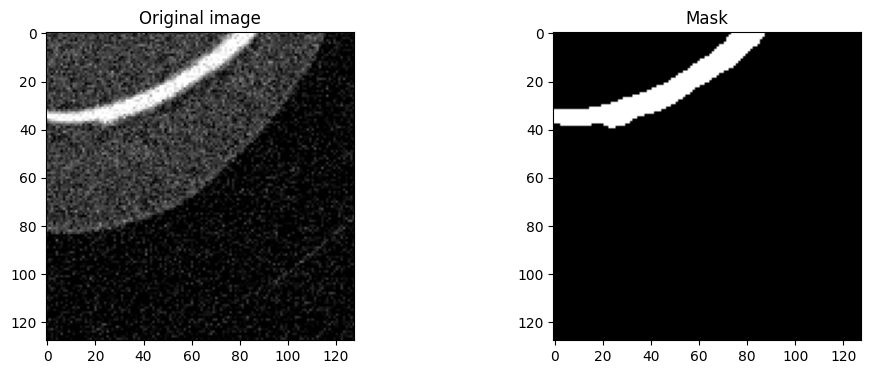

In [ ]:
# Check the patches
# Change the patch and slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_3D[110,:,:,25,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_3D[110,:,:,25,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [ ]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.75, 0.25]))
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
# others: vgg16, resnet50
backbone = 'vgg16' #resnet50, vgg16
preprocess_input = sm.get_preprocessing(backbone)

In [ ]:
train_original_3D = preprocess_input(train_original_3D)
validation_original_3D = preprocess_input(validation_original_3D)
test_original_3D = preprocess_input(test_original_3D)

In [ ]:
# Define the model
model = sm.Unet(backbone, classes=2,
                input_shape=(128, 128, 64, 3),
                encoder_weights='imagenet',
                activation='sigmoid')

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

176619520/176606448 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 block1_conv1 (Conv3D)          (None, 128, 128, 64  5248        ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 block1_conv2 (Conv3D)          (None, 128, 128, 64  110656      ['block1_conv1[0][0]']           
                           

In [ ]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,43,0], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,43,0], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,43,0], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir_resn = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/resnet50_noise'
save_dir_vgg = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/vgg16_noise'
os.makedirs(save_dir_vgg, exist_ok=True) # save_dir_vgg, save_dir_resn

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_3D, validation_mask_3D),
                                                    save_dir=save_dir_vgg) # save_dir_vgg, save_dir_resn

In [ ]:
history=model.fit(train_original_3D,
          train_mask_3D,
          batch_size=4,
          epochs=70,
          verbose=1,
          validation_data=(validation_original_3D, validation_mask_3D))
          #callbacks=[save_predictions_callback])

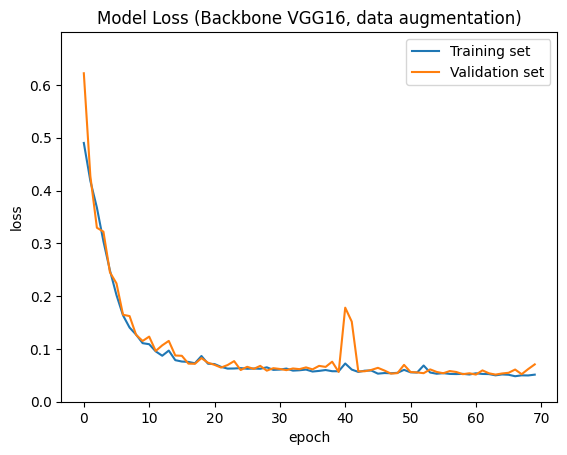

In [ ]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 0.7)
plt.yticks(np.arange(0, 0.7, 0.1))
plt.title('Model Loss (Backbone VGG16, data augmentation)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [ ]:
model.save('/content/drive/MyDrive/3DPart/3D/3DUNetModel/m_resnet50_totalLoss_noise.h5')

In [ ]:
model.save('/content/drive/MyDrive/3DPart/3D/3DUNetModel/m_vgg16_totalLoss_noise.h5')

In [ ]:
test_prediction = model.predict(test_original_3D)

In [ ]:
print(test_prediction.shape)

In [ ]:
binary_mask = (test_prediction > 0.5).astype(int)

In [ ]:
test_original_3D.shape

(16, 128, 128, 64, 3)

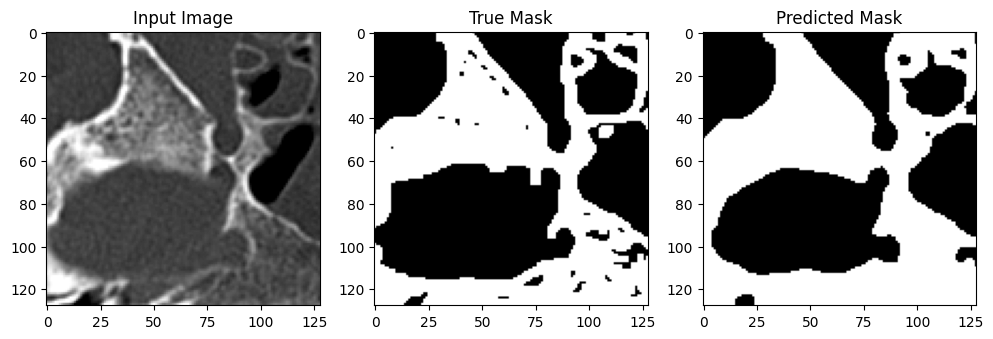

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(test_original_3D[5,:,:,43,0], cmap='gray')
axes[0].set_title('Input Image')

axes[1].imshow(test_mask_3D[5,:,:,43,0], cmap='gray')
axes[1].set_title('True Mask')

axes[2].imshow(binary_mask[5,:,:,43,0], cmap='gray')
axes[2].set_title('Predicted Mask')

plt.show()
